# 设置随机种子

In [1]:
seed=321654

# 导入公共库

In [2]:
from time import time
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from joblib import dump, load
import seaborn as sns
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')
import logging
logging.basicConfig(level=logging.ERROR)

# 导入 SMOTETomek 采样好的数据

In [3]:
# 读取数据
SMOTETomek=np.load(file='./data/new_experiment/CombineSampledData-0515-SMOTETomek.npz')
X, y=SMOTETomek['X'], SMOTETomek['y']

# 模型清单

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

models={
        # "LogisticReg": LogisticRegression(),
        # "AdaBoost": AdaBoostClassifier(),
        # "DecisionTree": DecisionTreeClassifier(random_state=seed, criterion='log_loss', splitter='best', min_samples_split=40, min_samples_leaf=40, max_leaf_nodes=40),
        "DecisionTree": DecisionTreeClassifier(random_state=seed),
        "RF_5": RandomForestClassifier(n_estimators=5, n_jobs=-1, random_state=seed),
        # "Bagging": BaggingClassifier(n_jobs=-1, random_state=seed),
}

# 开始实验

In [5]:
from datetime import datetime

def print_poster(info: str, length: int=60):
    print(r'-'*length)
    t=datetime.fromtimestamp(time()).strftime("%Y_%m_%d %H:%M:%S")
    print(r' '*int((length-len(t))/2-1), t, r' '*int((length-len(t)/2-1)))
    print(r' '*int((length-len(info))/2-1), info, r' '*int((length-len(info)/2-1)))
    print(r'-'*length)

In [6]:
from time import time_ns
def run(f):
    t0=time_ns()
    res=f()
    t1=time_ns()
    return res, (t1-t0)/1e6

## 切分数据集

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
test_size=0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y)

## 运行实验

In [9]:
from sklearn.metrics import accuracy_score

In [11]:
# print_poster("0325 EXPERIMENT START")

# 创建输出 dict
# 三层 dict，1→模型，2→evil，3→结果
performance=defaultdict(
    lambda : defaultdict(float)
)

import gc

# smooth round
R=10

shard=200

t=tqdm(range(R*len(models)))

# 遍历清单中的所有模型
for model_name, model in models.items():
    # 写入当前模型名称
    perf=performance[model_name]
    
    _, train_time = run(lambda : model.fit(X_train, y_train))
    perf['train time']+=(train_time)
    
    
    for _ in range(R):
        gc.collect()
            
        y_pred, test_pred_time = run(lambda : np.array([model.predict(p.reshape(1, -1)) for p in X_test[:shard, :]]))
        # y_pred, test_pred_time = run(lambda : model.predict(X_test[:200, :]))
        perf['test time']+=test_pred_time/R
        test_acc = accuracy_score(y_test[:shard], y_pred)
        perf['test acc']+=test_acc/R
        t.update(1)

    
# 输出数据
with open('model_compare_v3.csv', 'a') as f:
    header = f'{"method":^15}\t{"train time":^15}\t{"train acc":^15}\t{"test acc":^15}\t{"test time":^15}'
    # f.write(header+"\n")
    print(header)
    for method, perf in performance.items():
        row = f"{method:^15s}\t{perf['train time']:^15.3f}\t{perf['train acc']:^15.3f}\t{perf['test acc']:^15.3f}\t{perf['test time']:^15.3f}"
        f.write(row+"\n")
        print(row)


# print_poster("0325 EXPERIMENT END")


 50%|█████     | 10/20 [13:00<13:00, 78.03s/it]

100%|██████████| 20/20 [00:32<00:00,  1.47it/s]

    method     	  train time   	   train acc   	   test acc    	   test time   
 DecisionTree  	   17954.535   	     0.000     	     0.855     	     8.334     
     RF_5      	   7961.026    	     0.000     	     0.900     	    465.601    


# 绘图

In [22]:
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt

In [23]:
%matplotlib inline

In [24]:
compare_data=pd.read_csv('model_compare_output_temp.txt', index_col='method')
compare_data

,train time(s),train acc,train pred avg time(ns),test acc,test pred avg time(ns)
method,,,,,
LR,3.671,0.497,36.836,0.496,31.331
AdaBoost,99.771,0.565,5034.418,0.566,4475.339
DT,14.882,0.992,414.251,0.847,413.093
RF_5,6.669,0.980,880.320,0.885,948.734
Bag,23.769,0.986,2125.418,0.871,2375.054


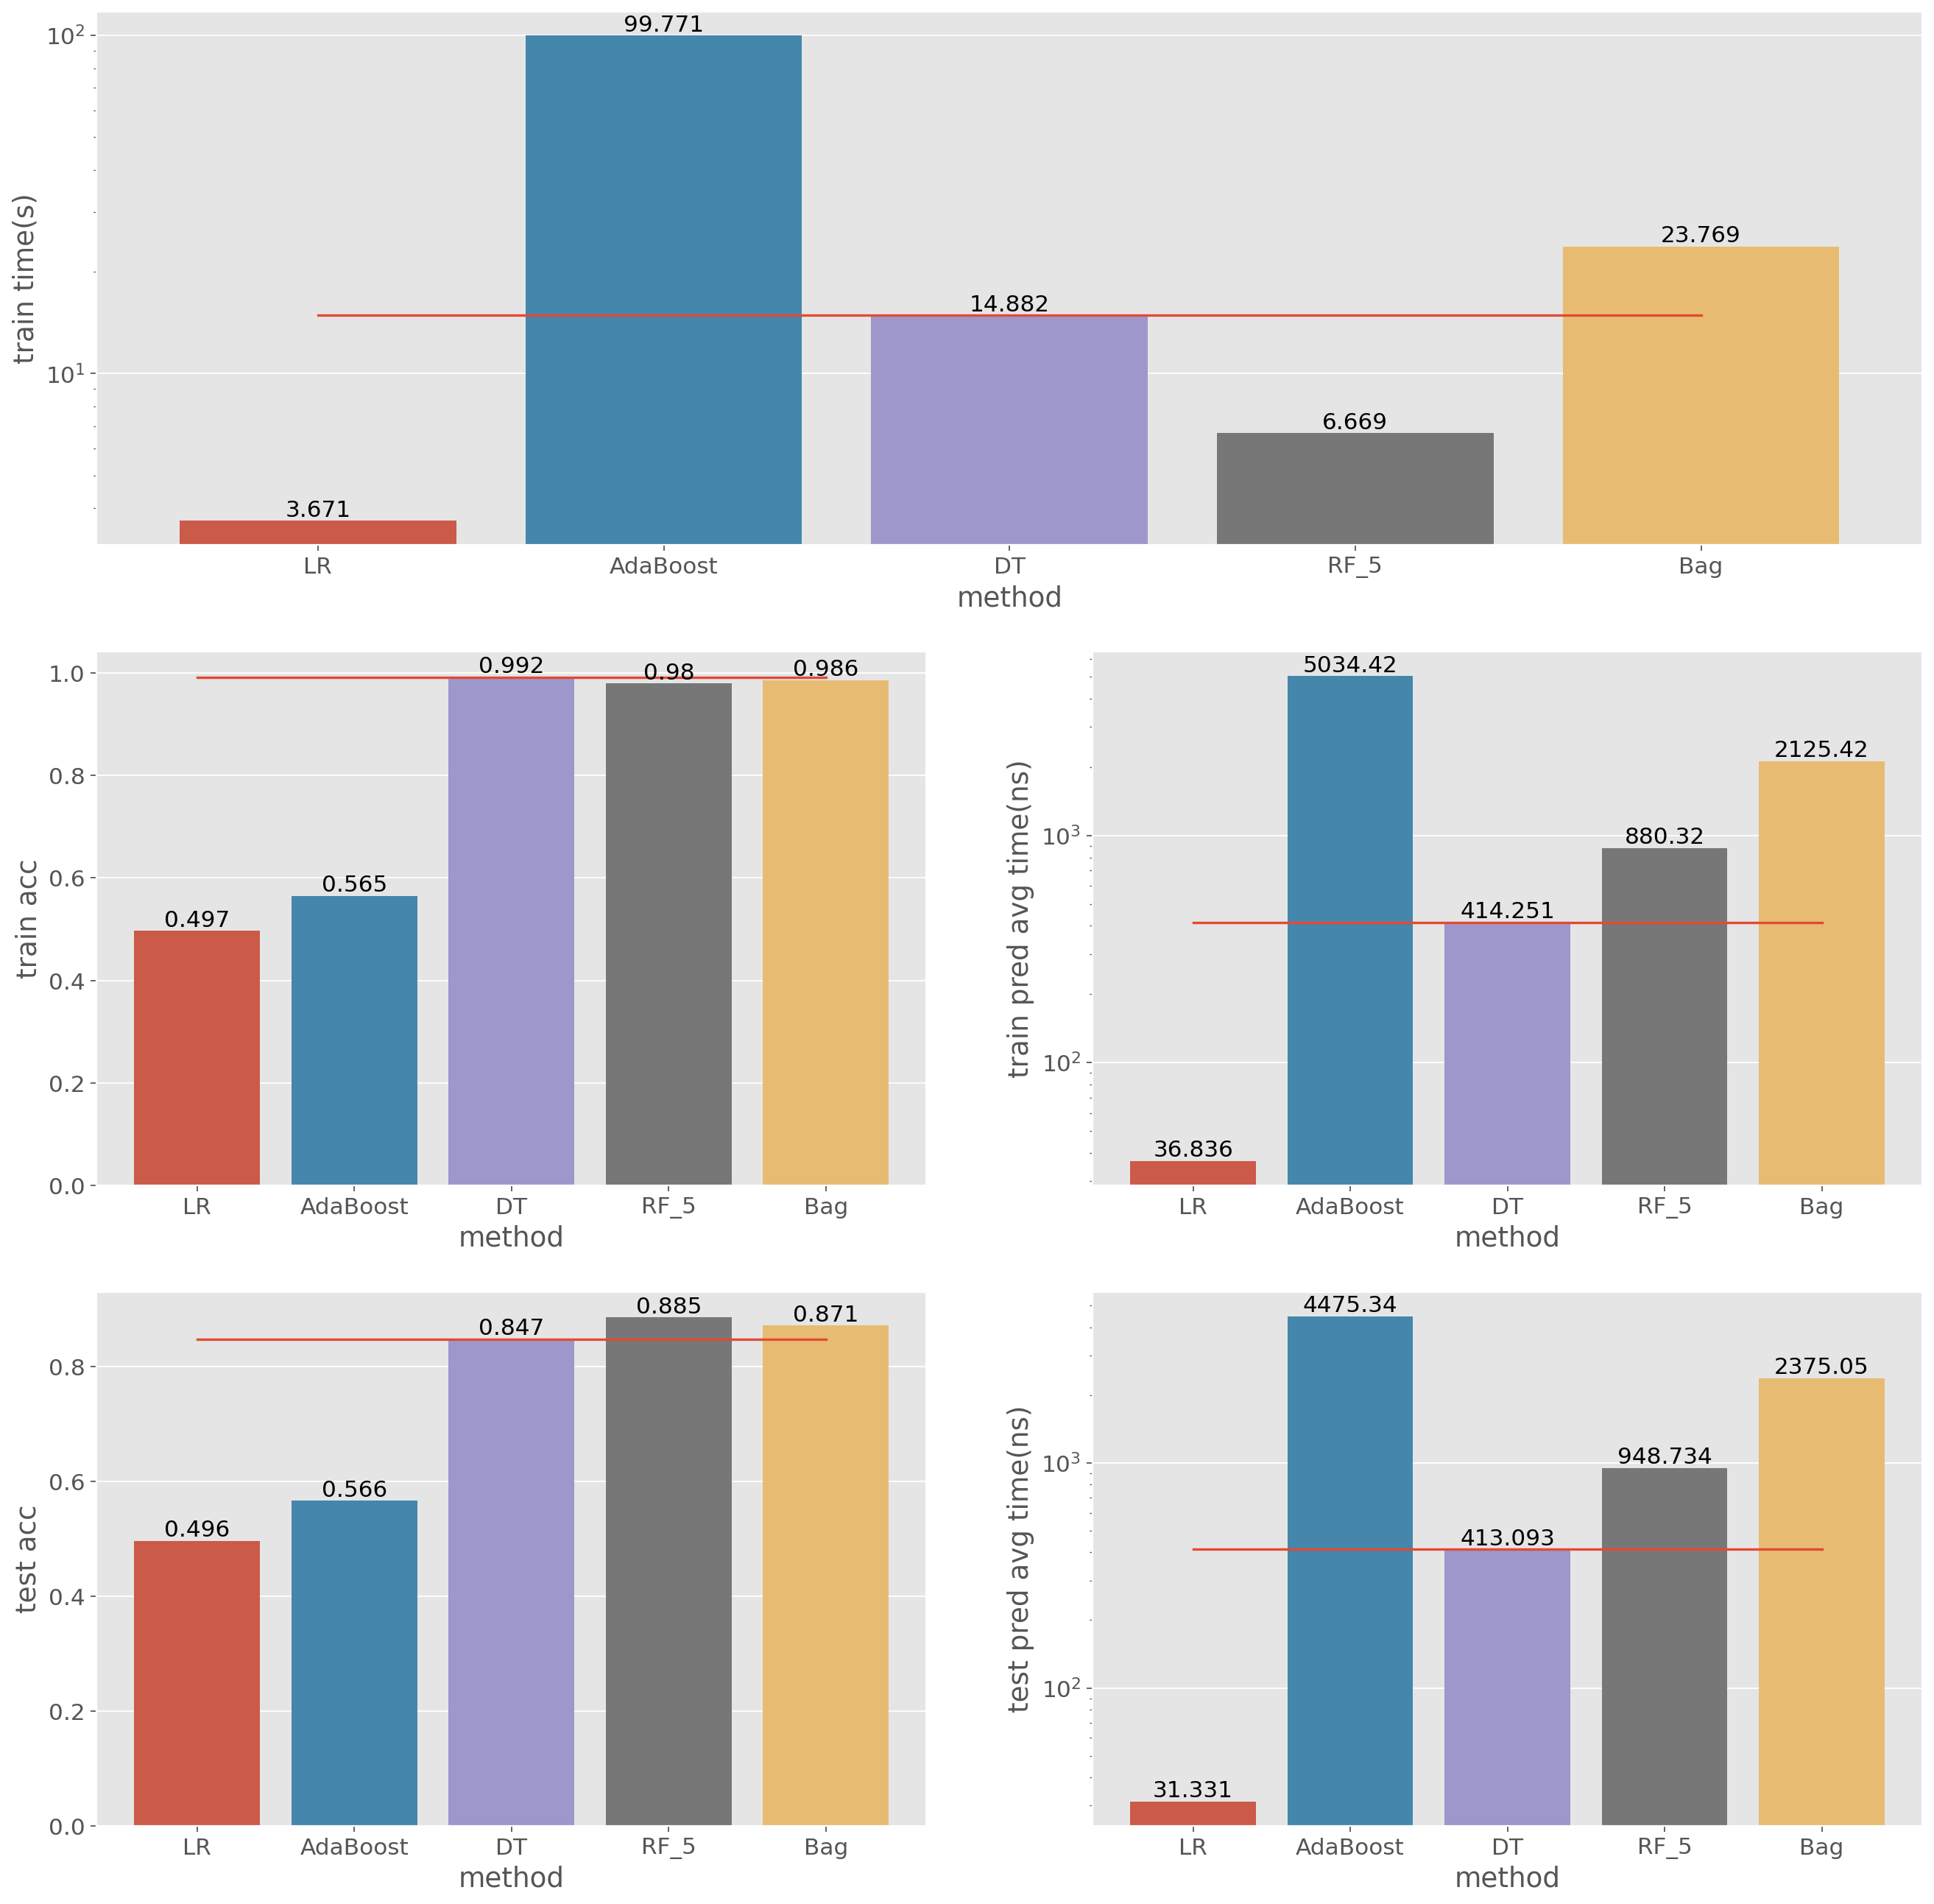

In [25]:
# figs, axes = plt.subplots(len(temp.columns), 1, figsize=(20, 60), dpi=50)
fig = plt.figure(figsize=(20, 20), dpi=80)
plt.rcParams.update({'font.size': 14})
axes = []
r, c = 3, 2
for i in range(r):
    if i == 0:
        axes.append(plt.subplot(r, c, (1, 2)))
        continue
    for j in range(c):
        axes.append(plt.subplot(r, c, i*c+j+1))
        
for col, a in zip(compare_data.columns, axes):
    x=compare_data.index
    # y=np.log10(compare_data[col]) if "time" in col else compare_data[col]
    y=compare_data[col]
    bar=sns.barplot(x=x, y=y, ax=a, log="time" in col, )
    sns.lineplot(x=x, y=np.ones(len(x))*compare_data[col].loc['DT'], ax=a)
    bar.bar_label(bar.containers[0])
    # if "acc" in col:
    #     a.set_ylim(bottom=np.min(y)-0.01)